# IEEE- FRAUD DETECTION USING CATBOOST AND FASTAI

## Load packages

In [1]:
import pickle
import pandas as pd
import numpy as np
from utils.data import get_data, export, balanceSample
from functools import partial
import optuna
from optuna.samplers import TPESampler
import json
# import random

## Load the dataset & artifacts

In [2]:
X_train, y_train, X_valid, y_valid,_ = get_data('data/train-balance.csv', valid_pct=0.2,hp=True)

In [3]:
# X_valid.to_csv('data/X_valid.csv', index=False)
# y_valid.to_csv('data/y_valid.csv', index=False)

In [4]:
with open('artifacts/features.txt') as json_file:
        features = json.load(json_file)

## Catboost model

In [5]:
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

### Define the training function

In [6]:
def train(params,train_data,val_data, plot_status=False):
    
    model = CatBoostClassifier(**params)

    model.fit(train_data, eval_set=val_data, plot=plot_status, verbose=False)

    predictions = model.predict(val_data)


    auc = roc_auc_score(val_data.get_label(), predictions)

    accuracy = accuracy_score(val_data.get_label(), predictions)

    print(f'Average AUC: {auc}, Average Accuracy: {accuracy}')
    return model

### Define the objective function to be maximized by Optuna

In [7]:
def objective(trial, X_train, y_train,X_valid,y_valid):

    params = {
        'iterations': trial.suggest_int('iterations', 120,200),
        'custom_metric': trial.suggest_categorical('custom_metric',['AUC']),
        'loss_function': trial.suggest_categorical('loss_function',['Logloss']),
        'learning_rate': trial.suggest_float('learning_rate', 0.04, 0.07),
        'subsample': trial.suggest_float('subsample', 0.5, 0.7),
#         'depth': trial.suggest_int('depth', 10,20),
        'scale_pos_weight':trial.suggest_int('scale_pos_weight', 1, 4)
    }
        
    X_train, y_train = balanceSample(X_train,y_train)
    
    train_data = Pool(
        data=X_train,
        label=y_train,
        cat_features=features['cat'],
    )
    
    val_data = Pool(
        data=X_valid,
        label=y_valid,
        cat_features=features['cat'],
    )
      
    model = train(params,  train_data, val_data)
    predictions = model.predict(val_data)


    auc = roc_auc_score(y_valid, predictions)

    return auc

### Run Hyperparameter optimization with Optuna

In [8]:
optimization_function = partial(objective,X_train=X_train,y_train=y_train, X_valid=X_valid, y_valid=y_valid)
sampler = TPESampler(seed=42)  # Make the sampler behave in a deterministic way.
study = optuna.create_study(sampler=sampler,direction="maximize")
study.optimize(optimization_function,n_trials=10)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
params = {}
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    params[key] = value

#save the best params to a file
with open('artifacts/catboost-params.txt', 'w') as outfile:
    json.dump(params, outfile)

[I 2021-06-20 02:19:32,291] A new study created in memory with name: no-name-8edf6afb-f73a-48ea-8cc0-6794721ffbb0


X shape : (29482, 817), y shape: (29482,)


[I 2021-06-20 02:19:42,959] Trial 0 finished with value: 0.842140034028769 and parameters: {'iterations': 150, 'custom_metric': 'AUC', 'loss_function': 'Logloss', 'learning_rate': 0.06852142919229749, 'subsample': 0.646398788362281, 'scale_pos_weight': 3}. Best is trial 0 with value: 0.842140034028769.


Average AUC: 0.842140034028769, Average Accuracy: 0.8247926267281106
X shape : (24199, 817), y shape: (24199,)


[I 2021-06-20 02:19:51,939] Trial 1 finished with value: 0.7969611410811565 and parameters: {'iterations': 132, 'custom_metric': 'AUC', 'loss_function': 'Logloss', 'learning_rate': 0.04467983561008608, 'subsample': 0.5116167224336399, 'scale_pos_weight': 4}. Best is trial 0 with value: 0.842140034028769.


Average AUC: 0.7969611410811565, Average Accuracy: 0.7458064516129033
X shape : (31252, 817), y shape: (31252,)


[I 2021-06-20 02:20:03,464] Trial 2 finished with value: 0.8221859740187931 and parameters: {'iterations': 168, 'custom_metric': 'AUC', 'loss_function': 'Logloss', 'learning_rate': 0.06124217733388137, 'subsample': 0.5041168988591604, 'scale_pos_weight': 4}. Best is trial 0 with value: 0.842140034028769.


Average AUC: 0.8221859740187931, Average Accuracy: 0.7802764976958525
X shape : (26182, 817), y shape: (26182,)


[I 2021-06-20 02:20:14,795] Trial 3 finished with value: 0.836449488474108 and parameters: {'iterations': 187, 'custom_metric': 'AUC', 'loss_function': 'Logloss', 'learning_rate': 0.04637017332034829, 'subsample': 0.5363649934414201, 'scale_pos_weight': 1}. Best is trial 0 with value: 0.842140034028769.


Average AUC: 0.836449488474108, Average Accuracy: 0.8890322580645161
X shape : (26205, 817), y shape: (26205,)


[I 2021-06-20 02:20:24,403] Trial 4 finished with value: 0.8414818065889558 and parameters: {'iterations': 144, 'custom_metric': 'AUC', 'loss_function': 'Logloss', 'learning_rate': 0.05574269294896714, 'subsample': 0.5863890037284232, 'scale_pos_weight': 2}. Best is trial 0 with value: 0.842140034028769.


Average AUC: 0.8414818065889558, Average Accuracy: 0.851889400921659
X shape : (31243, 817), y shape: (31243,)


[I 2021-06-20 02:20:36,488] Trial 5 finished with value: 0.8456629446980667 and parameters: {'iterations': 169, 'custom_metric': 'AUC', 'loss_function': 'Logloss', 'learning_rate': 0.044184815819561254, 'subsample': 0.5584289297070436, 'scale_pos_weight': 2}. Best is trial 5 with value: 0.8456629446980667.


Average AUC: 0.8456629446980667, Average Accuracy: 0.8570506912442396
X shape : (24332, 817), y shape: (24332,)


[I 2021-06-20 02:20:47,457] Trial 6 finished with value: 0.8322281471139479 and parameters: {'iterations': 156, 'custom_metric': 'AUC', 'loss_function': 'Logloss', 'learning_rate': 0.06355527884179041, 'subsample': 0.5399347564316719, 'scale_pos_weight': 3}. Best is trial 5 with value: 0.8456629446980667.


Average AUC: 0.8322281471139479, Average Accuracy: 0.8148387096774193
X shape : (24269, 817), y shape: (24269,)


[I 2021-06-20 02:20:57,901] Trial 7 finished with value: 0.8300658112244251 and parameters: {'iterations': 167, 'custom_metric': 'AUC', 'loss_function': 'Logloss', 'learning_rate': 0.04139351238159993, 'subsample': 0.6215089703802876, 'scale_pos_weight': 1}. Best is trial 5 with value: 0.8456629446980667.


Average AUC: 0.8300658112244251, Average Accuracy: 0.8846082949308756
X shape : (27879, 817), y shape: (27879,)


[I 2021-06-20 02:21:07,510] Trial 8 finished with value: 0.8157127898176338 and parameters: {'iterations': 125, 'custom_metric': 'AUC', 'loss_function': 'Logloss', 'learning_rate': 0.0684665661176, 'subsample': 0.6931264066149119, 'scale_pos_weight': 4}. Best is trial 5 with value: 0.8456629446980667.


Average AUC: 0.8157127898176338, Average Accuracy: 0.772811059907834
X shape : (31210, 817), y shape: (31210,)


[I 2021-06-20 02:21:18,888] Trial 9 finished with value: 0.8433672123480426 and parameters: {'iterations': 144, 'custom_metric': 'AUC', 'loss_function': 'Logloss', 'learning_rate': 0.042930163420191514, 'subsample': 0.6368466053024313, 'scale_pos_weight': 2}. Best is trial 5 with value: 0.8456629446980667.


Average AUC: 0.8433672123480426, Average Accuracy: 0.8510599078341013
Number of finished trials:  10
Best trial:
  Value: 0.8456629446980667
  Params: 
    iterations: 169
    custom_metric: AUC
    loss_function: Logloss
    learning_rate: 0.044184815819561254
    subsample: 0.5584289297070436
    scale_pos_weight: 2


### Retrain the model with the best parameters

In [9]:
with open('artifacts/catboost-params.txt') as json_file:
        params = json.load(json_file)

In [10]:
train_data = Pool(
        data=X_train,
        label=y_train,
        cat_features=features['cat'],
    )
    
val_data = Pool(
    data=X_valid,
    label=y_valid,
    cat_features=features['cat'],
)

In [11]:
model = train(params,train_data,val_data,plot_status=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Average AUC: 0.8443157326034544, Average Accuracy: 0.8836866359447004


In [12]:
predictions = model.predict(val_data)
auc_1 = roc_auc_score(val_data.get_label(), predictions)
auc_1

0.8443157326034544

### Save the model

In [13]:
model_filename = './artifacts/catboost-model.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(model, model_file)

In [14]:
from explainerdashboard import ClassifierExplainer, InlineExplainer

### Analyse the model

In [15]:
explainer = ClassifierExplainer(model, X_valid, y_valid)

Note: model_output=='probability'. For CatBoostClassifier shap values normally get calculated against X_background, but paramater X_background=None, so using X instead
Generating self.shap_explainer = shap.TreeExplainer(model, X, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...


In [16]:
# ie = InlineExplainer(explainer,mode='inline')

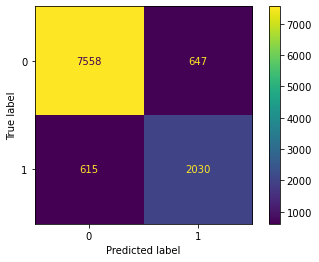

In [18]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(model, X_valid, y_valid)  
plt.show()

In [19]:
# ie.classifier.confusion_matrix()

In [20]:
# ie.importances()

In [21]:
df_importances = explainer.get_importances_df()

Calculating shap values...


 98%|===================| 10606/10850 [00:42<00:00]        

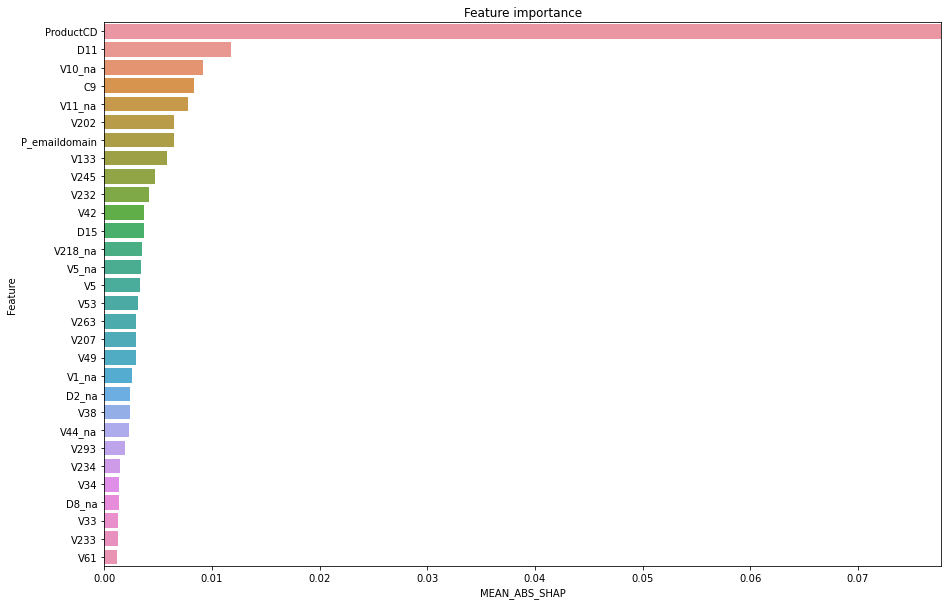

In [22]:
import seaborn as sns
plt.figure(figsize=(15, 10))
ax = sns.barplot(x="MEAN_ABS_SHAP", y="Feature", data=df_importances[:30], orient="h")
ax.set_xlim(df_importances["MEAN_ABS_SHAP"].min(), df_importances["MEAN_ABS_SHAP"].max())
plt.title('Feature importance')
plt.show()

### Retrain the model with only important features and compare it to the model with all features

In [23]:
important_cols = df_importances[df_importances['MEAN_ABS_SHAP']>0].Feature.values.tolist()

In [24]:
cat = list(set(features['cat']).intersection(set(important_cols)))

In [25]:
train_data_important = Pool(
        data=X_train[important_cols],
        label=y_train,
        cat_features=cat,
    )
    
val_data_important = Pool(
    data=X_valid[important_cols],
    label=y_valid,
    cat_features=cat,
)

In [26]:
model2 = train(params,train_data_important,val_data_important, plot_status=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Average AUC: 0.7926828931134942, Average Accuracy: 0.851705069124424


In [27]:
predictions = model2.predict(val_data_important)
auc_2 = roc_auc_score(val_data.get_label(), predictions)
auc_2

0.7926828931134942

### Save important features and useless features so that you can use them later if needed

In [28]:
not_important_cols = df_importances[df_importances['MEAN_ABS_SHAP']==0].Feature.values.tolist()

In [29]:
noneNa_not_important_cols = [c.split('_na')[0] for c in not_important_cols]
noneNa_important_cols = [c.split('_na')[0] for c in important_cols]

In [30]:
useless = set(noneNa_not_important_cols).difference(set(noneNa_important_cols))

In [31]:
feature_imp = {}
feature_imp['useless']  = list(useless)
feature_imp['important'] = important_cols
with open('artifacts/catboost-feature-importance.txt', 'w') as outfile:
    json.dump(feature_imp, outfile)

## Fit the model to the test set

In [32]:
df_test = pd.read_csv('data/test.csv', low_memory=False)

In [33]:
df_test[df_test.duplicated()]

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,day,hour,id_31_v


In [34]:
df_test.shape

(506691, 436)

### Prepocess the test set

In [35]:
with open('artifacts/data-proc.pkl', 'rb') as preproc_file:
    preproc = pickle.load(preproc_file)

    data_proc = preproc.train.new(df_test)
    data_proc.process()

### Use the model that showed good performance between the model with all features vs the one with only important features

In [36]:
if auc_1 < auc_2:
    cat = list(set(important_cols).intersection(set(features['cat'])))
    test_data = Pool(
        data=data_proc.train.xs[important_cols],
        label=None,
        cat_features=cat,
    )
    y_test_hat = model2.predict_proba(test_data)[:,1]
else:
    cat = features['cat']
    test_data = Pool(
        data=data_proc.train.xs,
        label=None,
        cat_features= cat
    )
    y_test_hat = model.predict_proba(test_data)[:,1]

In [37]:
y_test_hat.shape

(506691,)

In [38]:
df_test['isFraud'] = y_test_hat

In [39]:
df_test[['TransactionID']].duplicated().any()

False

In [40]:
df_test.shape

(506691, 437)

## Submit the result to Kaggle for evaluation

In [41]:
df_test[['TransactionID', 'isFraud']].to_csv('data/submission_catboost_v1.csv', index=False)

In [42]:
!kaggle competitions submit -c ieee-fraud-detection -f data/submission_catboost_v1.csv -m "Submission without any deep feature engineering. just using fastai and catboost"

100%|██████████████████████████████████████| 13.4M/13.4M [00:10<00:00, 1.32MB/s]
Successfully submitted to IEEE-CIS Fraud Detection

In [ ]:
import gc
gc.collect()